In [1]:
import numpy as np
%matplotlib inline

from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
from scipy.stats import rankdata
from typing import Tuple

import matplotlib.pyplot as plt
#phi = (np.sqrt(5)+1)/2
fig_width = 5
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)

# Fix hexagonal points

### Set square pattern

In [3]:
N = 121
N_X = int(np.sqrt(N))
N_Y = N // N_X
xv_square, yv_square = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')


### Convert into hexagonal pattern

In [4]:
ratio = np.sqrt(3) * 1/ 2 
xv_hexagonal, yv_hexagonal = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')

In [5]:
xv_hexagonal = xv_hexagonal * ratio
xv_hexagonal[::2, :] += ratio/2

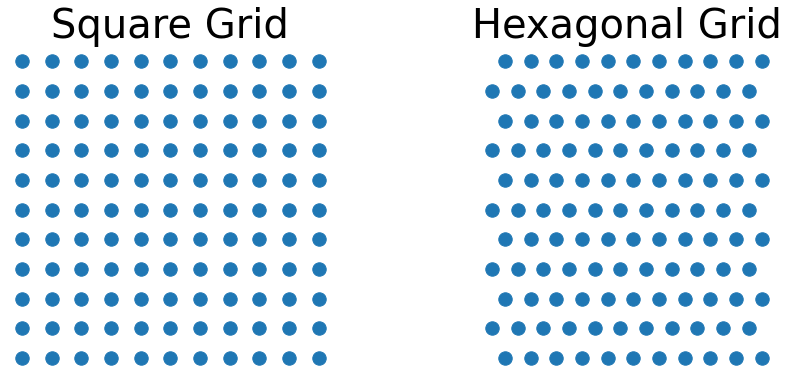

In [6]:
fz = 40
marker_size  = 180
fig,ax = plt.subplots(1,2,figsize = (15,6))


ax[0].scatter(xv_square,yv_square, s=marker_size)
ax[1].scatter(xv_hexagonal, yv_hexagonal, s=marker_size)

ax[0].set_title("Square Grid",fontsize=fz)
ax[1].set_title("Hexagonal Grid",fontsize=fz)

for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")

# Assign values to Hexagonal Grid

In [7]:
grid = np.zeros((N_X,N_Y))

In [8]:
def take_step(pos, shape):
    x = np.random.choice([-1,0,1])
    y = np.random.choice([-1,0,1])
    for k,s in enumerate([x,y]):
        if pos[k] + s < shape[k] and pos[k] + s >= 0:
            pos[k] = pos[k] + s
    return pos

In [9]:
n_steps = int(1e4)
shape = (N_X,N_Y)
pos = np.array([np.random.uniform(0,shape[0],size=1).astype(int)[0], 
                np.random.uniform(0,shape[1],size=1).astype(int)[0]])
grid[pos[0],pos[1]] = 1
for step in range(n_steps):
    pos = take_step(pos, shape)
    grid[pos[0],pos[1]] += 1

In [10]:
original_values = grid.flatten()

In [11]:
square_positions = np.vstack([xv_square.flatten(), yv_square.flatten()]).T
hexagonal_positions = np.vstack([xv_hexagonal.flatten(), yv_hexagonal.flatten()]).T

In [12]:
def grid2img(positions: np.array, values : np.array, shape: Tuple[int, int]):
    #Create img by adding values to grid
    img = np.zeros(shape)
    for v, p in zip(values,positions):
        img[(p[0]), p[1]] = v
    return np.rot90(img)

In [13]:
original_img = grid2img(square_positions, original_values, (N_X,N_Y))

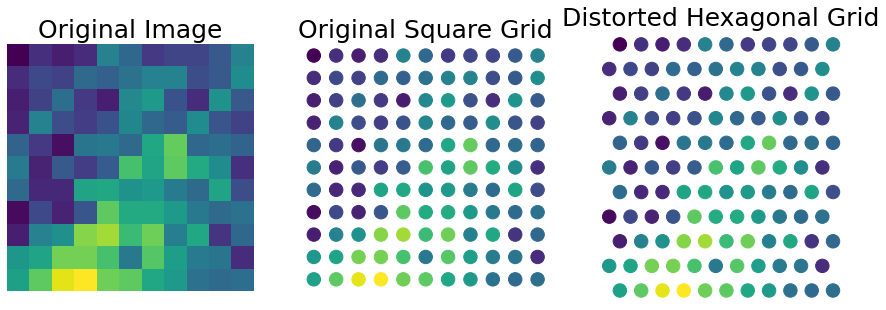

In [14]:
fig,ax = plt.subplots(1,3,figsize = (15,6))

ax[0].imshow(original_img)
ax[1].scatter(xv_square, yv_square, c = original_values, s=marker_size)
ax[2].scatter(xv_hexagonal, yv_hexagonal, c = original_values, s=marker_size)


ax[0].set_title("Original Image",fontsize=fz - 15 )
ax[1].set_title("Original Square Grid",fontsize=fz - 15 )
ax[2].set_title("Distorted Hexagonal Grid",fontsize=fz - 15 )


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")
    

# Set-up square grid

In [15]:
def Hexagon2SquareImg(hexagonal_positions: np.ndarray, square_positions: np.ndarray,
                      original_values: np.ndarray, bins : Tuple[int,int]):
    #Setup number of bins that hexagonal will be divided into
    bin_x, bin_y = bins
    
    #Bin Hexagonal
    ret = binned_statistic_2d(hexagonal_positions[:,0], hexagonal_positions[:,1], None,'count', bins=[bin_x, bin_y], expand_binnumbers=True)
    #Take bin edges as new posiontal points for square grid
    xx,yy=np.meshgrid(ret.x_edge, ret.y_edge)
    new_vals = griddata(square_positions,original_values,(xx,yy),method = "nearest")
    new_vals = new_vals.flatten()
    
    
    #Get new points and adjust them to a 2x2 grid
    new_positions = np.vstack([xx.flatten(), yy.flatten()]).T
    new_positions = rankdata(new_positions, "dense", axis=0) - 1
    I = grid2img(new_positions, new_vals, (bin_x + 1, bin_y + 1))
    return I

In [16]:
#Run interpolation for different number of bins

distortedImgs = [original_img]
for i in range(2, 11):
    distortedImgs.append(Hexagon2SquareImg(hexagonal_positions, square_positions,original_values, (N_X - i, N_Y - i)))

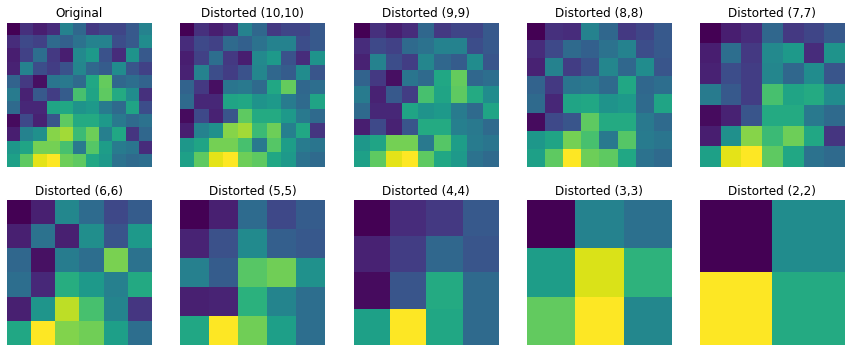

In [17]:
fig,ax = plt.subplots(2,5,figsize = (15,6))
for i, img in enumerate(distortedImgs):
    ax[int(i/5),i%5].imshow(img)
    if int(i/5) == 0 and i%5==0:
        ax[int(i/5),i%5].set_title("Original")
    else:
        ax[int(i/5),i%5].set_title(f"Distorted ({10 - (i-1)},{10 - (i-1)})")

for aa in ax:
    for a in aa:
        a.set_aspect("equal")
        a.axis("off")